### CARMENES NIR data for HD189733

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from astropy.io import fits
import warnings  
with warnings.catch_warnings():  # suppress annoying TensorFlow FutureWarnings 
    warnings.filterwarnings("ignore",category=FutureWarning)
    import wobble

In [2]:
data_dir = '/Users/mbedell/python/wobble/data/hd_189733_b/'
with fits.open(data_dir+'original_spectra.fits') as hdus:
    flux = np.copy(hdus[0].data)
with fits.open(data_dir+'wavelength.fits') as hdus:
    wave = np.copy(hdus[0].data)
with fits.open(data_dir+'noise.fits') as hdus:
    noise = np.copy(hdus[0].data)

In [3]:
flux.shape, wave.shape, noise.shape

((28, 45, 4080), (45, 4080, 28), (45, 4080, 28))

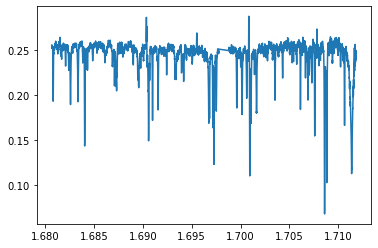

In [29]:
n, r = 5, 27 # epoch, order
plt.plot(wave[n,:,r], flux[r,n,:]);

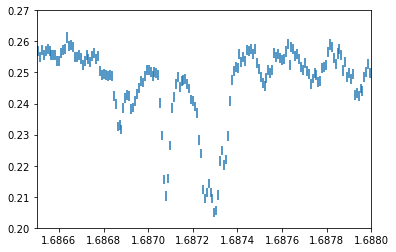

In [30]:
plt.errorbar(wave[n,:,r], flux[r,n,:], noise[n,:,r], ls='')
plt.xlim([1.6865,1.688])
plt.ylim([0.2,0.27]);

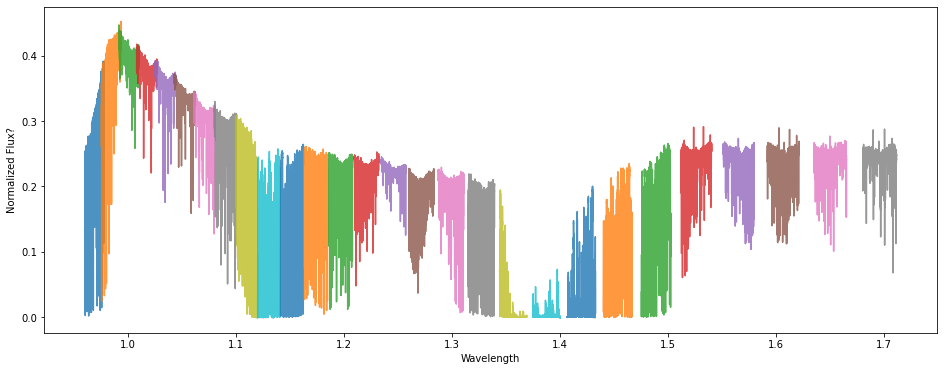

In [6]:
fig, ax = plt.subplots(1,1,figsize=(16,6))
for r in range(28):
    ax.plot(wave[n,:,r], flux[r,n,:], alpha=0.8)
ax.set_xlabel('Wavelength')
ax.set_ylabel('Normalized Flux?');

In [7]:
with fits.open(data_dir+'julian_date.fits') as hdus:
    date = np.copy(hdus[0].data)
with fits.open(data_dir+'berv.fits') as hdus:
    berv = np.copy(hdus[0].data)
with fits.open(data_dir+'airmass.fits') as hdus:
    airm = np.copy(hdus[0].data)

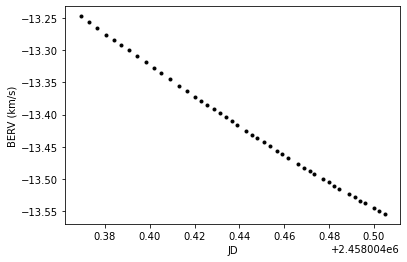

In [8]:
plt.plot(date, berv, 'k.')
plt.xlabel('JD')
plt.ylabel('BERV (km/s)');

### convert to wobble format:

#### figure out the correct processing to apply:

In [9]:
n_orders = 28
n_epochs = 45

#for n in range(n_epochs):
for n in range(1):
    xs = [wave[n,:,r] for r in range(n_orders)]
    ys = [flux[r,n,:] for r in range(n_orders)]
    ivars = [noise[n,:,r]**-0.5 for r in range(n_orders)]
    sp = wobble.Spectrum(xs, ys, ivars,
                        dates=date[n], bervs=berv[n]*1.e3, airms=airm[n])
    

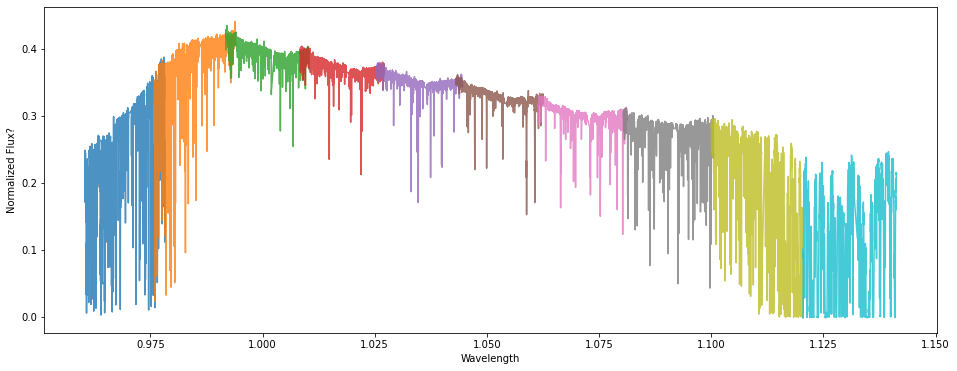

In [10]:
fig, ax = plt.subplots(1,1,figsize=(16,6))
for r in range(10):
    ax.plot(sp.xs[r], sp.ys[r], alpha=0.8)
ax.set_xlabel('Wavelength')
ax.set_ylabel('Normalized Flux?');

Mask the zero/negative fluxes:

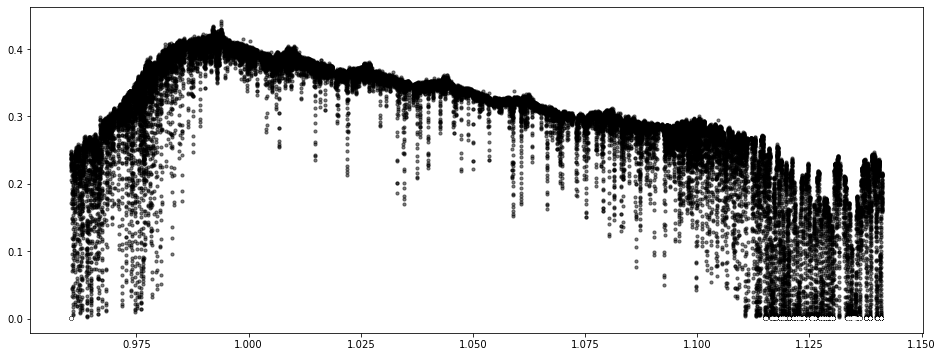

In [11]:
sp.mask_low_pixels(min_flux=1.e-3, padding=0)
fig, ax = plt.subplots(1,1,figsize=(16,6))
for r in range(10):
    mask = sp.ivars[r] <= 1.e-8
    ax.scatter(sp.xs[r], sp.ys[r], marker=".", alpha=0.5, c='k', s=40)
    ax.scatter(sp.xs[r][mask], sp.ys[r][mask], marker=".", alpha=1., c='white', s=20) 

Trim low-SNR edges:

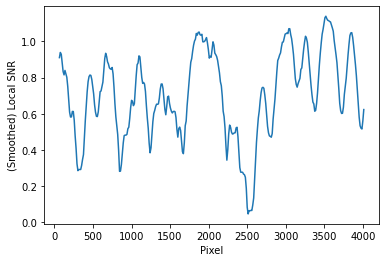

In [12]:
r = 9
n_pix = len(sp.xs[r])
window_width = 128
window_mid, window_snr = [], []
for window_start in range(0, n_pix - window_width, int(window_width/10)):
    window_end = window_start+window_width
    mean_snr = np.sqrt(np.nanmean(sp.ys[r][window_start:window_end]**2 * 
                                  sp.ivars[r][window_start:window_end]))
    window_mid.append(window_start+window_width/2)
    window_snr.append(mean_snr)
plt.plot(window_mid, window_snr)
plt.xlabel('Pixel')
plt.ylabel('(Smoothed) Local SNR');

The edges don't look particularly bad so I'm not going to do this step.

Transform to log wavelength and continuum normalize:

In [13]:
sp.transform_log()

In [14]:
from wobble.utils import fit_continuum

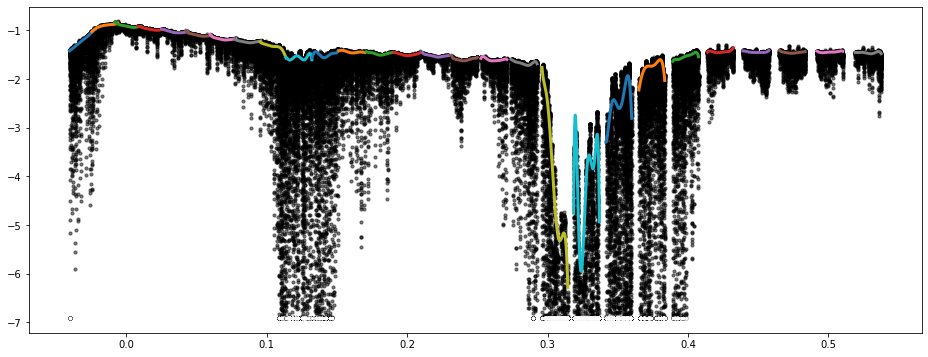

In [15]:
fig, ax = plt.subplots(1,1,figsize=(16,6))
for r in range(n_orders):
    cont = fit_continuum(sp.xs[r], sp.ys[r], sp.ivars[r], order=6, nsigma=[0.3,3.0], maxniter=50)
    mask = sp.ivars[r] <= 1.e-8
    ax.scatter(sp.xs[r], sp.ys[r], marker=".", alpha=0.5, c='k', s=40)
    ax.scatter(sp.xs[r][mask], sp.ys[r][mask], marker=".", alpha=1., c='white', s=20) 
    ax.plot(sp.xs[r], cont, lw=3)

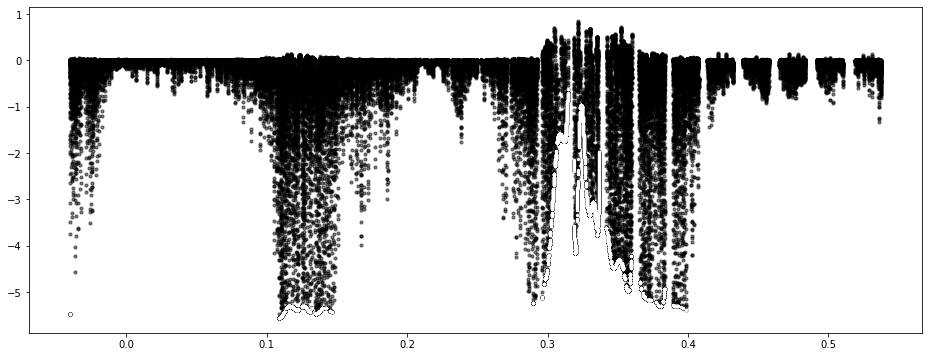

In [16]:
sp.continuum_normalize()
fig, ax = plt.subplots(1,1,figsize=(16,6))
for r in range(n_orders):
    mask = sp.ivars[r] <= 1.e-8
    ax.scatter(sp.xs[r], sp.ys[r], marker=".", alpha=0.5, c='k', s=40)
    ax.scatter(sp.xs[r][mask], sp.ys[r][mask], marker=".", alpha=1., c='white', s=20) 

Mask high pixels: I don't see any cosmic rays, so I think this step should be skipped.

#### make & write out the data structure:

In [17]:
data = wobble.Data()

In [18]:
n_orders = 28
n_epochs = 45

for n in range(n_epochs):
    xs = [wave[n,:,r] for r in range(n_orders)]
    ys = [flux[r,n,:] for r in range(n_orders)]
    ivars = [noise[n,:,r]**-0.5 for r in range(n_orders)]
    sp = wobble.Spectrum(xs, ys, ivars,
                        dates=date[n], bervs=berv[n]*1.e3, airms=airm[n])
    sp.mask_low_pixels(min_flux=1.e-3, padding=0)
    sp.transform_log()
    sp.continuum_normalize()
    data.append(sp)

In [19]:
data.write(data_dir[:-1]+'.hdf5')